<a href="https://colab.research.google.com/github/sarthakkaushik/BERT/blob/main/Fine_Tune_BERT_for_Text_Classification_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In this [project](https://www.coursera.org/projects/fine-tune-bert-tensorflow/), you will learn how to fine-tune a BERT model for text classification using TensorFlow and TF-Hub.

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Learning Objectives

By the time you complete this project, you will be able to:

- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

### Prerequisites

In order to be successful with this project, it is assumed you are:

- Competent in the Python programming language
- Familiar with deep learning for Natural Language Processing (NLP)
- Familiar with TensorFlow, and its Keras API

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Task 4]()**: Create tf.data.Datasets for Training and Evaluation
- **[Task 5]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[Task 6]()**: Tokenize and Preprocess Text for BERT
- **[Task 7]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[Task 8]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[Task 9]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[Task 10]()**: Fine-Tune BERT for Text Classification
- **[Task 11]()**: Evaluate the BERT Text Classification Model

## Task 2: Setup your TensorFlow and Colab Runtime.

You will only be able to use the Colab Notebook after you save it to your Google Drive folder. Click on the File menu and select “Save a copy in Drive…

![Copy to Drive](https://drive.google.com/uc?id=1CH3eDmuJL8WR0AP1r3UE6sOPuqq8_Wl7)


### Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).

![Hardware Accelerator Settings](https://drive.google.com/uc?id=1qrihuuMtvzXJHiRV8M7RngbxFYipXKQx)


In [1]:
!nvidia-smi

Sun Dec 19 16:28:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.7.0


In [ ]:
!pip install -q tensorflow==2.3.0

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 13.78 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

## Restart the Runtime

**Note** 
After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)

![Restart of the Colab Runtime Engine](https://drive.google.com/uc?id=1xnjAy2sxIymKhydkqb0RKzgVK9rh3teH)

## Task 3: Download and Import the Quora Insincere Questions Dataset

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [3]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df= pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [5]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<AxesSubplot:title={'center':'class distribution'}, ylabel='Frequency'>

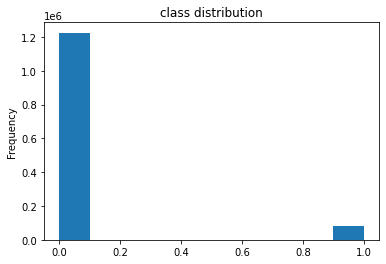

In [6]:
#Printing the distribution of our class label, to know if their is any imbalance in the dataset.

df.target.plot(kind='hist', title='class distribution')

## Task 4: Create tf.data.Datasets for Training and Evaluation

The major issue while using BERT model is the bottle neck between IO devices and the GPU to process the data.
This issue can be overcome efficiently by using tensorflow data objet created with command - "tf.data.Dataset.from_tensor_slices'.
THis command will return a python iterator of the data we want and the we can loop over that data and process that data on CPU 

In [7]:
train_df, remaining= train_test_split(df,random_state=42, train_size=0.0075,stratify=df.target.values)
valid_df,_=train_test_split(remaining, random_state=42, train_size=0.00075,stratify=remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [20]:
with tf.device('/cpu:0'):
  train_data=tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data=tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values,valid_df['target'].values))

  for text, label in train_data.take(1):
    print(text)
    print(label)
  

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [9]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list=[0,1] # Label categories. If it would be multi-class , then we cand our value here , and we need to update our softmanx layer. Also we need to update our loss function from 'Binary cross entropy ' to 'SParse categorical cross entropy'
max_seq_length=128 # maximum length of (token) input sequences, which translate t the length of the largest question we allow.BERT allow maximum 512 token . But due to constrained memory we will set it as 128. Although we can do experiment with this value
train_batch_size=32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

#Lets download the Bert as a Keras layer from above URL mae all paratere as trainable as per the tensorflow guide

bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

#Now we need to tokenize the string for that we first need to used BERT voab to make it tokenized

#Instantiation 
vocab_file= bert_layer.resolved_object.vocab_file.asset_path.numpy() # downloading the vocab file as a numpy
do_lower_case= bert_layer.resolved_object.do_lower_case.numpy() #This will help us to know which bert model( Cased or Uncased ) to dowload. In our project its is Cased
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case) #Instantiate our Tokenizer




In [10]:
tokenizer.wordpiece_tokenizer.tokenize("hi, how are you doing?")

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [11]:
# Now we need to create Token ID of our tokens above
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi, how are you doing?"))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [12]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  #creating input example
  example= classifier_data_lib.InputExample(guid=None,
                                            text_a=text.numpy(),
                                            text_b=None,
                                            label=label.numpy()) # text_a- first sentence (here our questions) would be a tensore hence converting t numpy, text_b- None becuase there sencond sentecne, we have one question at a time
  
  # Now we will be converting our examaple into feature
  feature= classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length,tokenizer) # we are taking only first sentence hence 0
  # This will return feature objetct
  return( feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)#segment_ids are nothing ut input type IDS

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [25]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label],
                                                               Tout=[tf.int32,tf.int32,tf.int32,tf.int32])
  # So we just converted our graphe tesnsor as a regular  tesnor ans passsed this to to our To_feature funcntio to get 3 output in int32 format.
  #Now the wrapper function do not shae the output, we need to shape it to our max_seq_length
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([]) # we leave this empty becuase we cant determineshape for label because label could be binary as some time multiclasss, hence we leave thi as blank

  #Now we will bundle our input feature  as dict in x

  x={
    'input_word_ids': input_ids,
    'input_mask': input_mask,
    'input_type_ids': segment_ids
  }

  return (x, label_id)

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [27]:
with tf.device('/cpu:0'):
  # train
  train_data=(train_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32,drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  

  # valid
  valid_data= (valid_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32,drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE)
  )
  
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [29]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [28]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [46]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids,input_mask, input_type_ids])

  #We can add some dense layer after this but for this time we are skipping it

  #we are adding dropout layer

  drop=tf.keras.layers.Dropout(0.4)(pooled_output)
  output=tf.keras.layers.Dense(1,activation='sigmoid', name='output')(drop)

  #now wrapping this ino keras model
  model = tf.keras.Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask' : input_mask,
          'input_type_ids' : input_type_ids
      },
      outputs=output
  )
  
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [47]:
model= create_model()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()]
              )
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',       

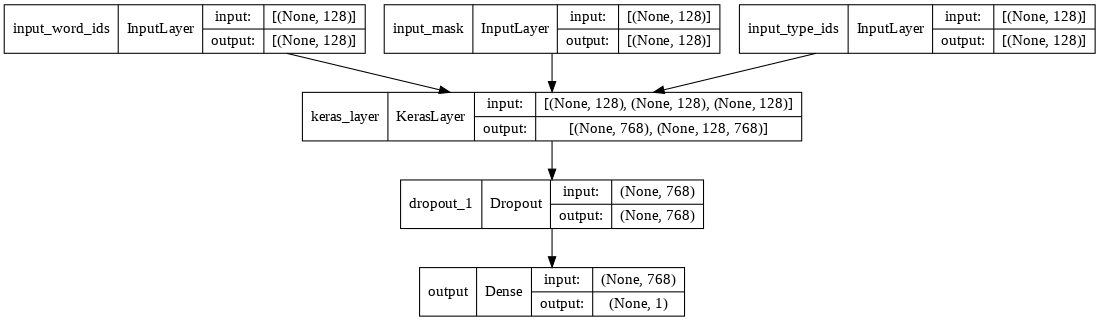

In [40]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [48]:
# Train model
epochs=4
history=model.fit(train_data,validation_data=valid_data,epochs=epochs,verbose=1)

Epoch 1/4
306/306 [==============================] - 163s 487ms/step - loss: 0.2086 - binary_accuracy: 0.9299 - val_loss: 0.1261 - val_binary_accuracy: 0.9521
Epoch 2/4
306/306 [==============================] - 149s 484ms/step - loss: 0.1043 - binary_accuracy: 0.9617 - val_loss: 0.1501 - val_binary_accuracy: 0.9573
Epoch 3/4
306/306 [==============================] - 149s 485ms/step - loss: 0.0613 - binary_accuracy: 0.9795 - val_loss: 0.1363 - val_binary_accuracy: 0.9646
Epoch 4/4
306/306 [==============================] - 149s 485ms/step - loss: 0.0292 - binary_accuracy: 0.9910 - val_loss: 0.2221 - val_binary_accuracy: 0.9625


## Task 11: Evaluate the BERT Text Classification Model

In [50]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

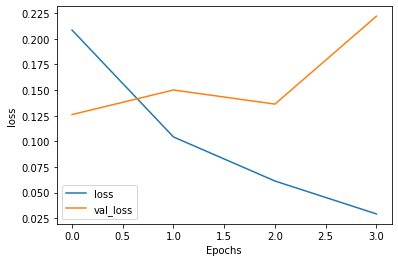

In [53]:
plot_graphs(history,'loss')

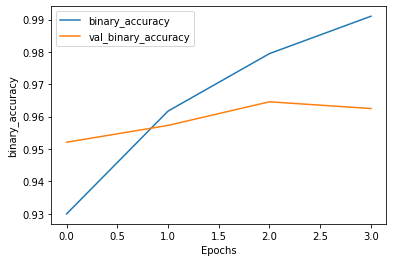

In [54]:
plot_graphs(history,'binary_accuracy')

In [56]:
sample_example=['How you doing ?']
test_data= tf.data.Dataset.from_tensor_slices((sample_example,[0]*len(sample_example)))
test_data=(test_data.map(to_feature_map).batch(1)) # We are going to send with batch =1
preds= model.predict(test_data)
threshold= 0.5
['Insincere' if pred>=threshold else 'Sincere' for pred in preds]


['Sincere']